In [4]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec
from gensim.models import Word2Vec
import os
import pickle

pd.set_option('display.max_columns', None)


# Load the dataset
df_pueblos = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")

pueblos_cmun = df_pueblos['cmun'].tolist()
user_files = os.listdir("../../data/user_output/")

user_choices = []

# Get all files from the user_output directory

# Read each file into a DataFrame and add to the list
for file in user_files:
    file_path = os.path.join("../../data/user_output/", file)
    user_df = pd.read_csv(file_path)
    user_choices.append(user_df)

# user choices of first user
user_choices_cmun = user_choices[0].cmun.tolist()
display(pueblos_cmun)
display(user_choices_cmun)

[42202,
 25076,
 40016,
 42098,
 50026,
 42121,
 17221,
 5239,
 26144,
 13089,
 49066,
 44067,
 44197,
 43058,
 5176,
 26023,
 45182,
 9365,
 34046,
 37180,
 44172,
 9294,
 2032,
 9463,
 43104,
 4095,
 10142,
 9440,
 47200,
 37254,
 42010,
 44156,
 19156,
 18027,
 5179,
 44106,
 37363,
 24090,
 22909,
 42031,
 40121,
 47149,
 43128,
 42131,
 31196,
 50160,
 28117,
 37096,
 19057,
 25121,
 26167,
 34238,
 44045,
 25097,
 19104,
 10117,
 10147,
 22236,
 45063,
 24034,
 31261,
 25031,
 20025,
 10042,
 34076,
 44113,
 40213,
 18079,
 6092,
 13032,
 25208,
 40087,
 50289,
 16271,
 26081,
 47124,
 44194,
 5222,
 8233,
 40065,
 49050,
 19011,
 11017,
 40060,
 9256,
 49067,
 40170,
 47216,
 9232,
 37128,
 10106,
 40220,
 32010,
 11040,
 6042,
 28056,
 49268,
 5218,
 37296,
 43097,
 18904,
 37248,
 24017,
 19293,
 32035,
 24183,
 44266,
 13006,
 24211,
 25131,
 34130,
 43168,
 19301,
 25041,
 1057,
 25192,
 34050,
 46107,
 5207,
 49034,
 5214,
 43158,
 20028,
 32011,
 43040,
 13901,
 44020,
 12

[4062, 43145, 31145, 4043, 25134]

In [5]:
df_pueblos_enc = df_pueblos.filter(regex=r"^enc_", axis=1)
# Select only numerical features with more than 2 unique values (non-binary features)
pueblos_numerical_features = df_pueblos_enc.loc[:, (df_pueblos_enc.nunique() > 2)]

# Process user choices: filter for encoded features and remove binary columns
processed_user_choices = []
for df in user_choices:
    df_filtered = df.filter(regex=r"^enc_", axis=1)
    df_non_binary = df_filtered.loc[:, ~(df_filtered.isin([0.0, 1.0]).all())]
    processed_user_choices.append(df_non_binary)

display(processed_user_choices[0])
display(pueblos_numerical_features)


,enc_scaled__age_score,enc_scaled__transport_score,enc_scaled__airport_distance_score,enc_scaled__train_distance_score,enc_scaled__school_score_area,enc_scaled__hospital_score_area,enc_scaled__school_distance_score,enc_scaled__hospital_distance_score,enc_scaled__economy_score_area,enc_scaled__economy_score,enc_scaled__connectivity_score,enc_scaled__number_of_houses,enc_scaled__total_population,enc_scaled__female
0,1.130323,-0.966116,-0.312065,-1.042193,0.720850,-0.876805,0.720850,-0.876805,1.977939,6.124961,1.015498,2.721049,3.604119,3.551278
1,1.336800,3.167961,3.889199,1.871512,0.720850,1.818041,0.720850,1.818041,2.510007,6.440695,0.574826,2.377454,3.888589,3.948157
2,0.139362,2.651202,3.889199,1.224022,-0.249725,0.278129,-0.249725,0.278129,-0.469336,-0.391445,0.944213,-0.653984,-0.573899,-0.562981
3,0.815159,0.584163,1.488477,-0.070958,0.720850,0.278129,0.720850,0.278129,0.789357,-0.391445,0.464659,-0.002128,-0.105822,-0.191401
4,0.309579,0.325783,-0.312065,0.576532,0.720850,0.278129,0.720850,0.278129,-0.150046,-0.391445,1.015498,-0.296986,-0.087698,-0.098111


,enc_scaled__age_score,enc_scaled__transport_score,enc_scaled__airport_distance_score,enc_scaled__train_distance_score,enc_scaled__school_score_area,enc_scaled__hospital_score_area,enc_scaled__school_distance_score,enc_scaled__hospital_distance_score,enc_scaled__economy_score_area,enc_scaled__economy_score,enc_scaled__connectivity_score,enc_scaled__number_of_houses,enc_scaled__total_population,enc_scaled__female
0,-3.320970,-0.966116,-1.512427,-0.394703,-2.190875,-0.876805,-2.190875,-0.876805,-0.591420,-0.391445,-1.659313,-0.750240,-0.700768,-0.689477
1,0.113225,0.325783,-0.312065,0.576532,0.720850,0.278129,0.720850,0.278129,-0.321864,-0.391445,-0.045678,-0.684445,-0.584931,-0.581956
2,-1.055578,-0.966116,-0.312065,-1.042193,0.720850,-0.876805,0.720850,-0.876805,-0.687007,-0.391445,-1.600989,-0.757550,-0.667672,-0.661015
3,-2.707746,-0.966116,-0.312065,-1.042193,0.720850,-0.876805,0.720850,-0.876805,-0.718080,-0.391445,-1.941213,-0.779482,-0.703920,-0.692639
4,0.847193,1.100923,0.288115,1.224022,0.720850,-0.106849,0.720850,-0.106849,-0.604946,-0.391445,0.851866,-0.282365,-0.246087,-0.257811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674,1.476295,1.617682,1.488477,1.224022,0.720850,1.818041,0.720850,1.818041,0.568530,0.248794,1.102984,0.084380,0.582109,0.575476
1675,0.454445,1.359303,-0.312065,1.871512,0.720850,-0.876805,0.720850,-0.876805,-0.744763,-0.391445,-0.321097,-0.042336,-0.226387,-0.243581
1676,-1.215245,-0.190976,0.288115,-0.394703,-0.249725,-0.491827,-0.249725,-0.491827,-0.649232,-0.391445,-0.288695,-0.740492,-0.698404,-0.687895
1677,-1.349493,-0.707736,0.288115,-1.042193,0.720850,-0.876805,0.720850,-0.876805,-0.704159,-0.391445,-1.746799,-0.498026,-0.626695,-0.619904


In [6]:
# 1️⃣ Construct the Graph
G = nx.Graph()
for i, row in pueblos_numerical_features.iterrows():
    # get cmun of row
    cmun = df_pueblos.iloc[i, 0]
    G.add_node(cmun, **row.to_dict())

# Compute pairwise feature similarity (Cosine Similarity)
feature_matrix = pueblos_numerical_features
similarity_matrix = cosine_similarity(feature_matrix)

# Add edges based on similarity threshold
threshold = 0.75  # Adjust threshold based on data distribution
for i in range(len(feature_matrix)):
    for j in range(i + 1, len(feature_matrix)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

In [5]:
# from sklearn.metrics import silhouette_score
# import numpy as np

# # Test different dimensions
# dimensions_to_test = [16, 24, 32, 48, 64]
# scores = []

# for dim in dimensions_to_test:
#     # Create and train model
#     node2vec = Node2Vec(G, dimensions=dim, walk_length=10, num_walks=20, workers=12)
#     model = node2vec.fit(window=5, min_count=1)
    
#     # Extract embeddings
#     embeddings = np.array([model.wv[str(node)] for node in G.nodes()])
    
#     # Evaluate using silhouette score (requires clustering)
#     from sklearn.cluster import KMeans
#     kmeans = KMeans(n_clusters=5, random_state=42)
#     clusters = kmeans.fit_predict(embeddings)
#     score = silhouette_score(embeddings, clusters)
    
#     scores.append((dim, score))
#     print(f"Dimensions: {dim}, Silhouette Score: {score:.4f}")

# # Find best dimension
# best_dim = max(scores, key=lambda x: x[1])[0]
# print(f"Best dimension: {best_dim}")

In [7]:
# 2️⃣ Generate Node2Vec Embeddings
node2vec = Node2Vec(G, dimensions=32, walk_length=5, num_walks=10, workers=2)

Generating walks (CPU: 2): 100%|██████████| 5/5 [00:00<00:00, 29.65it/s]


In [8]:
model = node2vec.fit(
    window=10,        # Increased from 5
    min_count=1,      # Keep as is
    batch_words=100,  # Increased from 4
    epochs=15,        # Added parameter
    sg=1,             # Added parameter (Skip-gram)
    hs=0,             # Added parameter (Negative sampling)
    negative=7        # Added parameter
)

In [9]:
display(similarity_matrix)

array([[ 1.        , -0.24025574,  0.47229631, ...,  0.71958137,
         0.45478629, -0.7250894 ],
       [-0.24025574,  1.        ,  0.23610225, ...,  0.14300468,
         0.17237636, -0.15985779],
       [ 0.47229631,  0.23610225,  1.        , ...,  0.70273099,
         0.9716193 , -0.70793209],
       ...,
       [ 0.71958137,  0.14300468,  0.70273099, ...,  1.        ,
         0.73231318, -0.77341725],
       [ 0.45478629,  0.17237636,  0.9716193 , ...,  0.73231318,
         1.        , -0.62461195],
       [-0.7250894 , -0.15985779, -0.70793209, ..., -0.77341725,
        -0.62461195,  1.        ]])

In [10]:
# Create models directory if it doesn't exist
os.makedirs('../../models', exist_ok=True)

# Save the Node2Vec embeddings
model_path = '../../models/node2vec_subset.model'
model.save(model_path)

print(f"Model saved to {model_path}")

# If you want to save the graph separately
graph_path = '../../models/village_graph.pkl'
with open(graph_path, 'wb') as f:
    pickle.dump(G, f)
    
print(f"Graph saved to {graph_path}")

Model saved to ../../models/node2vec_subset.model
Graph saved to ../../models/village_graph.pkl


In [11]:
# 3️⃣ Compute Similarity
user_selected_villages = user_choices_cmun # Example selected villages
selected_vectors = [model.wv[str(v)] for v in user_selected_villages]
centroid_vector = np.mean(selected_vectors, axis=0)

# Rank all villages based on cosine similarity
all_village_vectors = {v: model.wv[str(v)] for v in G.nodes()}
similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# 4️⃣ Evaluate Ranking Quality
def ndcg_at_k(ranked_list, ideal_list, k):
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
    ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
    return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

ndcg_score = ndcg_at_k(ranked_villages, user_selected_villages, k=10)
print(f"NDCG Score: {ndcg_score:.4f}")

# Display top similar villages
print("Top 10 Most Similar Villages:")
for village, score in ranked_villages[:10]:
    print(f"Village {village}: Similarity {score:.4f}")


NDCG Score: 1.0000
Top 10 Most Similar Villages:
Village 25134: Similarity 0.6331
Village 4062: Similarity 0.5303
Village 4043: Similarity 0.5072
Village 19215: Similarity 0.5018
Village 22195: Similarity 0.4963
Village 16149: Similarity 0.4950
Village 47041: Similarity 0.4917
Village 34241: Similarity 0.4818
Village 33050: Similarity 0.4671
Village 50131: Similarity 0.4639


/var/folders/w9/bt5d4t050m7fd91t2r7l1mlh0000gn/T/ipykernel_5368/3696273799.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")


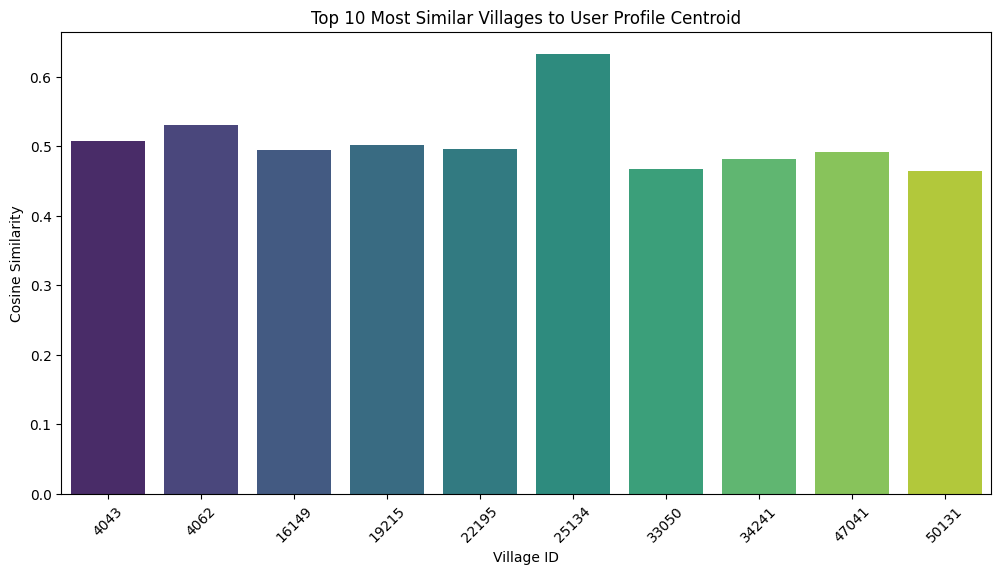

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract top 10 similar villages and their scores
top_villages = ranked_villages[:10]
village_ids = [v for v, _ in top_villages]
similarity_scores = [s for _, s in top_villages]

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")
plt.xlabel("Village ID")
plt.ylabel("Cosine Similarity")
plt.title("Top 10 Most Similar Villages to User Profile Centroid")
plt.xticks(rotation=45)
plt.show()

In [13]:
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from node2vec import Node2Vec
from gensim.models import Word2Vec
import random

# Load the full dataset
df_pueblos_full = pd.read_csv("../../data/end_product_data/pueblos_recommender.csv")

# Load the smaller model
pre_trained_model = Word2Vec.load("../../models/node2vec_embeddings.model")

# Filter encoded features
df_pueblos_enc_full = df_pueblos_full.filter(regex=r"^enc_", axis=1)
pueblos_numerical_features_full = df_pueblos_enc_full.loc[:, (df_pueblos_enc_full.nunique() > 2)]

# Construct the full graph
G_full = nx.Graph()
for i, row in pueblos_numerical_features_full.iterrows():
    cmun = df_pueblos_full.iloc[i, 0]
    G_full.add_node(cmun, **row.to_dict())

# Compute pairwise feature similarity (Cosine Similarity)
feature_matrix_full = pueblos_numerical_features_full
similarity_matrix_full = cosine_similarity(feature_matrix_full)

# Add edges based on similarity threshold
threshold = 0.75

# Use batching for edge creation to avoid memory issues
batch_size = 1000
for i in range(len(feature_matrix_full)):
    for j in range(i + 1, min(i + batch_size, len(feature_matrix_full))):
        if similarity_matrix_full[i, j] > threshold:
            G_full.add_edge(i, j, weight=similarity_matrix_full[i, j])

# Generate random walks on the full graph
node2vec_full = Node2Vec(G_full, dimensions=32, walk_length=5, num_walks=10, workers=2)
walks = node2vec_full.walks  # Get the random walks

# HERE'S THE KEY PART: Initialize a new Word2Vec model with the pre-trained weights
model_full = Word2Vec(
    vector_size=pre_trained_model.wv.vector_size,
    window=10, 
    min_count=1, 
    batch_words=100, 
    epochs=15, 
    sg=1, 
    hs=0, 
    negative=7,
    workers=2
)

# Build vocabulary from the walks
model_full.build_vocab(walks)

# Copy weights from pre-trained model for shared vocabulary items
for word in model_full.wv.index_to_key:
    if word in pre_trained_model.wv:
        model_full.wv[word] = pre_trained_model.wv[word]

# Train the model, starting from the pre-initialized weights
model_full.train(walks, total_examples=model_full.corpus_count, epochs=model_full.epochs)

# Save the full model
model_full.save("../../models/node2vec_full.model")

Generating walks (CPU: 2): 100%|██████████| 5/5 [00:00<00:00, 32.79it/s]


In [14]:
# 3️⃣ Compute Similarity
user_selected_villages = user_choices_cmun # Example selected villages
selected_vectors = [model_full.wv[str(v)] for v in user_selected_villages]
centroid_vector = np.mean(selected_vectors, axis=0)

# Rank all villages based on cosine similarity
all_village_vectors = {v: model_full.wv[str(v)] for v in G.nodes()}
similarities = {v: cosine_similarity([centroid_vector], [vec])[0][0] for v, vec in all_village_vectors.items()}
ranked_villages = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

# 4️⃣ Evaluate Ranking Quality
def ndcg_at_k(ranked_list, ideal_list, k):
    def dcg(scores):
        return sum([(2**s - 1) / np.log2(i+2) for i, s in enumerate(scores)])
    
    ideal_scores = [1 if v in ideal_list else 0 for v, _ in ranked_list[:k]]
    return dcg(ideal_scores) / dcg(sorted(ideal_scores, reverse=True))

ndcg_score = ndcg_at_k(ranked_villages, user_selected_villages, k=10)
print(f"NDCG Score: {ndcg_score:.4f}")

# Display top similar villages
print("Top 10 Most Similar Villages:")
for village, score in ranked_villages[:10]:
    print(f"Village {village}: Similarity {score:.4f}")


NDCG Score: 0.3562
Top 10 Most Similar Villages:
Village 21074: Similarity 0.6102
Village 5029: Similarity 0.6010
Village 22045: Similarity 0.5357
Village 17168: Similarity 0.5357
Village 43108: Similarity 0.5347
Village 31145: Similarity 0.5347
Village 48050: Similarity 0.5286
Village 40065: Similarity 0.5199
Village 20907: Similarity 0.5053
Village 26104: Similarity 0.4970


/var/folders/w9/bt5d4t050m7fd91t2r7l1mlh0000gn/T/ipykernel_5368/3696273799.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")


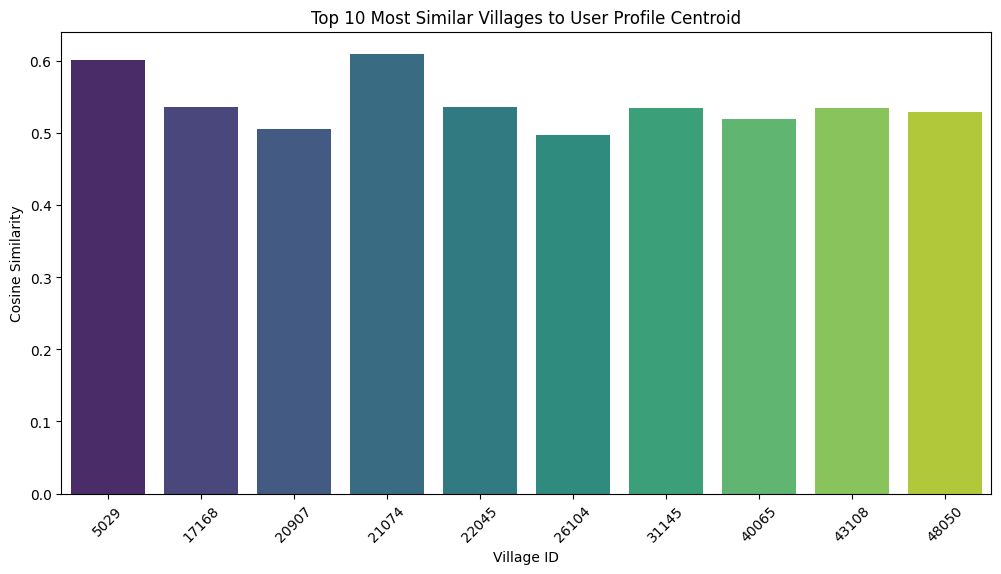

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract top 10 similar villages and their scores
top_villages = ranked_villages[:10]
village_ids = [v for v, _ in top_villages]
similarity_scores = [s for _, s in top_villages]

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=village_ids, y=similarity_scores, palette="viridis")
plt.xlabel("Village ID")
plt.ylabel("Cosine Similarity")
plt.title("Top 10 Most Similar Villages to User Profile Centroid")
plt.xticks(rotation=45)
plt.show()